# Modélisation

### Préparation des features pour la modélisation

#### A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation. OK fait
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer. OK fait
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn. Ok fait
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé). Ok fait
* Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne. Les deux méthodes d'encodage à connaitre sont le OneHotEncoder et le LabelEncoder

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [126]:
data_etape_1_clean = pd.read_csv(r"C:\Users\ethan\OpenClassroom\Projet_2\Projet\Anticipez_les_besoins_\Fichiers\data_etape_1_clean.csv")

In [127]:
print(data_etape_1_clean.columns.tolist())

['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


In [128]:
# 1 si un second usage existe
data_etape_1_clean["has_second_use"] = (
    data_etape_1_clean["SecondLargestPropertyUseTypeGFA"].fillna(0) > 0
).astype("int8")

# Part de GFA du 1er usage (protège division par zéro)
data_etape_1_clean["share_primary_gfa"] = (
    data_etape_1_clean["LargestPropertyUseTypeGFA"] / data_etape_1_clean["PropertyGFABuilding(s)"]
).where(data_etape_1_clean["PropertyGFABuilding(s)"].ne(0))

# Part de GFA du 2e usage (protège division par zéro)
data_etape_1_clean["share_second_gfa"] = (
    data_etape_1_clean["SecondLargestPropertyUseTypeGFA"] / data_etape_1_clean["PropertyGFABuilding(s)"]
).where(data_etape_1_clean["PropertyGFABuilding(s)"].ne(0))

# Part du parking dans la surface totale (protège division par zéro)
data_etape_1_clean["parking_share"] = (
    data_etape_1_clean["PropertyGFAParking"] / data_etape_1_clean["PropertyGFATotal"]
).where(data_etape_1_clean["PropertyGFATotal"].ne(0))

# 1 si site multi-bâtiments
data_etape_1_clean["is_multi_building"] = (
    data_etape_1_clean["NumberofBuildings"].fillna(1) > 1
).astype("int8")

# Présence d’électricité (pas la quantité)
data_etape_1_clean["has_electricity"] = (
    (data_etape_1_clean["Electricity(kWh)"].fillna(0) > 0) |
    (data_etape_1_clean["Electricity(kBtu)"].fillna(0) > 0)
).astype("int8")

# Présence de gaz (pas la quantité)
data_etape_1_clean["has_gas"] = (
    (data_etape_1_clean["NaturalGas(therms)"].fillna(0) > 0) |
    (data_etape_1_clean["NaturalGas(kBtu)"].fillna(0) > 0)
).astype("int8")

# Présence de vapeur (pas la quantité)
data_etape_1_clean["has_steam"] = (
    data_etape_1_clean["SteamUse(kBtu)"].fillna(0) > 0
).astype("int8")

# 1 si un troisième usage existe
data_etape_1_clean["has_third_use"] = (
    data_etape_1_clean["ThirdLargestPropertyUseTypeGFA"].fillna(0) > 0
).astype("int8")

# Nombre d'usages déclarés dans la liste des usages
data_etape_1_clean["n_declared_uses"] = (
    data_etape_1_clean["ListOfAllPropertyUseTypes"]
    .fillna("")
    .str.split(",")
    .apply(lambda lst: len({x.strip() for x in lst if x.strip() != ""}))
).astype("int8")

# Tranche d'âge du bâtiment (4 classes)
data_etape_1_clean["building_age_class"] = pd.cut(
    data_etape_1_clean["YearBuilt"],
    bins=[0, 1949, 1979, 1999, float("inf")],
    labels=["pre_1950", "1950_1979", "1980_1999", "2000_plus"],
    right=True
)

# Nombre de vecteurs d'énergie utilisés (électricité, gaz, vapeur)
data_etape_1_clean["n_energy_sources"] = (
    data_etape_1_clean["has_electricity"]
    + data_etape_1_clean["has_gas"]
    + data_etape_1_clean["has_steam"]
).astype("int8")

core_zips = {
    "98101", "98102", "98103", "98104", "98105",
    "98109", "98111", "98112", "98119", "98121",
    "98122", "98195"
}

def _zip_group_3(z):
    z = str(z)
    if z in core_zips:
        return "seattle_core"
    if z.startswith("981"):
        return "seattle_other"
    return "other_980"

data_etape_1_clean["zip_group_3"] = (
    data_etape_1_clean["ZipCode"].astype(str).apply(_zip_group_3)
)



#### supprimer toutes les colonnes peu pertinentes pour la modélisation.

In [129]:
data_etape_1_clean.drop(columns=[
    'ComplianceStatus', 
    'DefaultData', 
    'OSEBuildingID', 
    'PropertyName', 
    'TaxParcelIdentificationNumber', 
    'SteamUse(kBtu)', 
    'Electricity(kBtu)', 
    'Electricity(kWh)', 
    'NaturalGas(therms)', 
    'NaturalGas(kBtu)',   
    'SourceEUI(kBtu/sf)', 
    'SourceEUIWN(kBtu/sf)', 
    'SiteEnergyUseWN(kBtu)',
    'PropertyGFATotal',
    'TotalGHGEmissions',
    'SiteEUIWN(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)',
    'GHGEmissionsIntensity',
    'ListOfAllPropertyUseTypes',
    'Address',
    'YearBuilt',
    'ZipCode'
], inplace=True)

print(data_etape_1_clean.columns.tolist())


['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'has_second_use', 'share_primary_gfa', 'share_second_gfa', 'parking_share', 'is_multi_building', 'has_electricity', 'has_gas', 'has_steam', 'has_third_use', 'n_declared_uses', 'building_age_class', 'n_energy_sources', 'zip_group_3']


### Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn 

#### Préparation à une matrice de corrélation

In [130]:
data_etape_1_clean["CouncilDistrictCode"] = data_etape_1_clean["CouncilDistrictCode"].astype("string")
data_etape_1_clean["NumberofBuildings"] = data_etape_1_clean["NumberofBuildings"].astype("Int64")

print(data_etape_1_clean.columns.tolist())


['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'has_second_use', 'share_primary_gfa', 'share_second_gfa', 'parking_share', 'is_multi_building', 'has_electricity', 'has_gas', 'has_steam', 'has_third_use', 'n_declared_uses', 'building_age_class', 'n_energy_sources', 'zip_group_3']


In [131]:
s = data_etape_1_clean["NumberofBuildings"]
print("dtype:", s.dtype)
print("nunique:", s.nunique(dropna=True))
print("std:", s.std())
print("% NaN:", s.isna().mean())
print(s.value_counts(dropna=False).head())


dtype: Int64
nunique: 9
std: 0.7799097719652802
% NaN: 0.0
NumberofBuildings
1    1326
0      42
2      14
3      10
5       7
Name: count, dtype: Int64


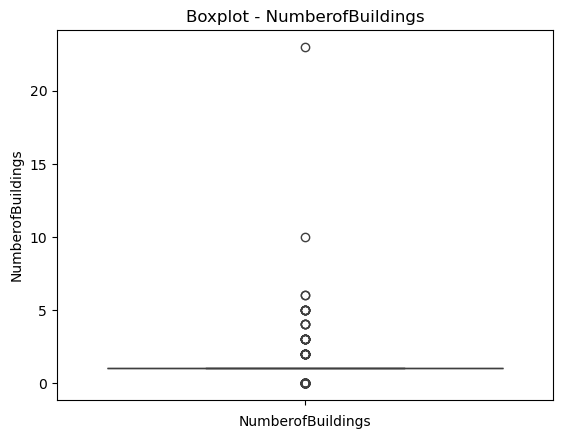

In [132]:
s = data_etape_1_clean["NumberofBuildings"].dropna()

plt.figure()
sns.boxplot(y=s)
plt.xlabel("NumberofBuildings")
plt.title("Boxplot - NumberofBuildings")
plt.show()

data_etape_1_clean.loc[data_etape_1_clean["NumberofBuildings"] == 0, "NumberofBuildings"] = 1


In [133]:
display(data_etape_1_clean.columns)

colonnes_autorisees = [
    "Latitude",
    "Longitude",
    "YearBuilt",
    "SiteEnergyUse(kBtu)",
    "NumberofFloors",
    "PropertyGFABuilding(s)",
    "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseTypeGFA",
    "has_second_use",
    "has_third_use",
    "n_declared_uses",
    "share_primary_gfa",
    "share_second_gfa",
    "parking_share",
    "is_multi_building",
    "has_electricity",
    "has_gas",
    "has_steam",
    "n_energy_sources",
]
cols = [c for c in colonnes_autorisees if c in data_etape_1_clean.columns]
cols = [c for c in cols if data_etape_1_clean[c].dtype.kind in "if"]
corr = data_etape_1_clean[cols].corr(method="pearson").round(2)
print("Colonnes utilisées pour la corrélation :", cols)
display(corr)
display(data_etape_1_clean["NumberofBuildings"])


Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'has_second_use',
       'share_primary_gfa', 'share_second_gfa', 'parking_share',
       'is_multi_building', 'has_electricity', 'has_gas', 'has_steam',
       'has_third_use', 'n_declared_uses', 'building_age_class',
       'n_energy_sources', 'zip_group_3'],
      dtype='object')

Colonnes utilisées pour la corrélation : ['Latitude', 'Longitude', 'SiteEnergyUse(kBtu)', 'NumberofFloors', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'has_second_use', 'has_third_use', 'n_declared_uses', 'share_primary_gfa', 'share_second_gfa', 'parking_share', 'is_multi_building', 'has_electricity', 'has_gas', 'has_steam', 'n_energy_sources']


,Latitude,Longitude,SiteEnergyUse(kBtu),NumberofFloors,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,has_second_use,has_third_use,n_declared_uses,share_primary_gfa,share_second_gfa,parking_share,is_multi_building,has_electricity,has_gas,has_steam,n_energy_sources
Latitude,1.00,-0.11,0.04,0.08,-0.02,-0.01,0.02,-0.04,0.00,0.02,0.04,0.02,0.11,0.02,-0.08,-0.00,-0.03,-0.03
Longitude,-0.11,1.00,-0.04,-0.08,-0.01,-0.01,-0.05,-0.06,-0.03,-0.07,0.02,-0.05,-0.05,0.04,0.04,0.06,-0.00,0.06
SiteEnergyUse(kBtu),0.04,-0.04,1.00,0.38,0.67,0.64,0.38,0.10,0.10,0.17,0.03,0.09,0.23,0.11,0.05,0.08,0.17,0.15
NumberofFloors,0.08,-0.08,0.38,1.00,0.44,0.40,0.33,0.20,0.16,0.16,-0.02,0.15,0.29,-0.06,0.04,-0.15,0.31,0.00
PropertyGFABuilding(s),-0.02,-0.01,0.67,0.44,1.00,0.92,0.44,0.07,0.09,0.10,-0.05,0.03,0.14,0.08,-0.03,0.01,0.15,0.07
LargestPropertyUseTypeGFA,-0.01,-0.01,0.64,0.40,0.92,1.00,0.31,-0.07,-0.06,-0.07,0.26,-0.02,0.24,0.10,-0.03,-0.00,0.11,0.04
SecondLargestPropertyUseTypeGFA,0.02,-0.05,0.38,0.33,0.44,0.31,1.00,0.56,0.35,0.44,-0.10,0.71,0.47,-0.03,0.03,-0.04,0.05,-0.01
has_second_use,-0.04,-0.06,0.10,0.20,0.07,-0.07,0.56,1.00,0.52,0.69,-0.36,0.70,0.24,-0.07,0.05,-0.05,0.02,-0.03
has_third_use,0.00,-0.03,0.10,0.16,0.09,-0.06,0.35,0.52,1.00,0.76,-0.36,0.40,0.10,-0.01,0.02,-0.02,0.01,-0.01
n_declared_uses,0.02,-0.07,0.17,0.16,0.10,-0.07,0.44,0.69,0.76,1.00,-0.39,0.50,0.14,0.03,0.03,0.00,0.03,0.02


0       1
1       1
2       1
3       1
4       1
       ..
1402    1
1403    1
1404    1
1405    1
1406    1
Name: NumberofBuildings, Length: 1407, dtype: Int64

 * Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn 


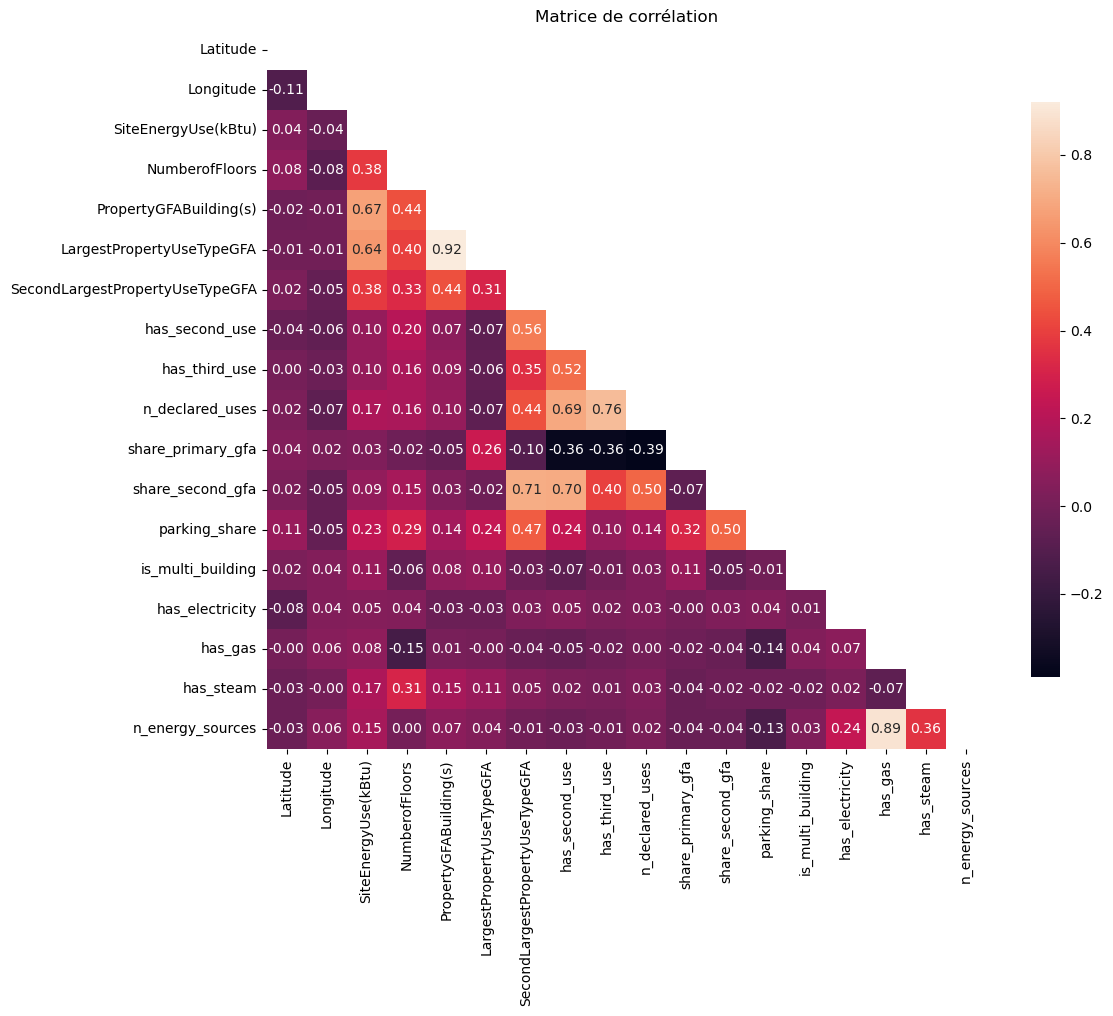

In [134]:
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()

Il en reste des corrélés mais ils restent tout de même interessants

On continue le nettoyage et description

### Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.

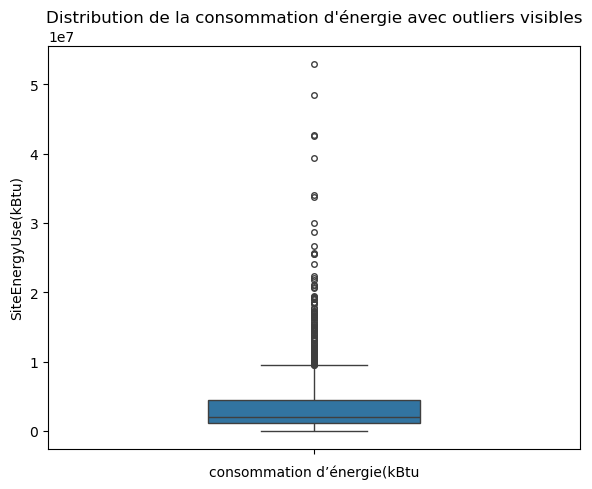

In [135]:
plt.figure(figsize=(6,5))
sns.boxplot(y=data_etape_1_clean["SiteEnergyUse(kBtu)"], width=0.4, fliersize=4)
plt.xlabel("consommation d’énergie(kBtu")
plt.title("Distribution de la consommation d'énergie avec outliers visibles")
plt.tight_layout()
plt.show()


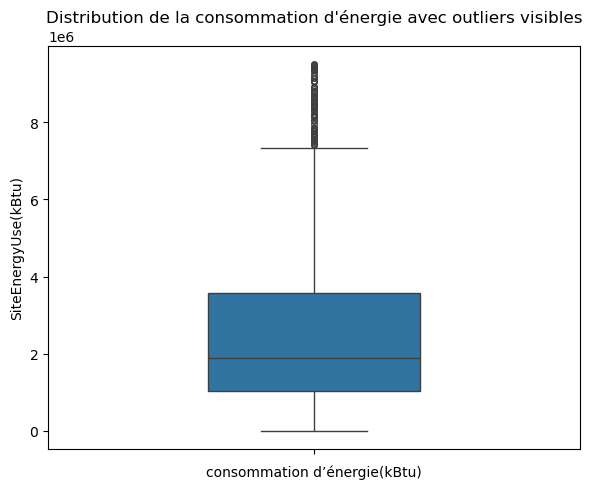

In [136]:
# Suppression des valeurs aberrantes sur  par méthode IQR
q1 = data_etape_1_clean["SiteEnergyUse(kBtu)"].quantile(0.25)
q3 = data_etape_1_clean["SiteEnergyUse(kBtu)"].quantile(0.75)
iqr = q3 - q1
lb = q1 - 1.5 * iqr
ub = q3 + 1.5 * iqr
data_etape_1_clean = data_etape_1_clean[data_etape_1_clean["SiteEnergyUse(kBtu)"].between(lb, ub)]

# Boxplot après nettoyage
plt.figure(figsize=(6,5))
sns.boxplot(y=data_etape_1_clean["SiteEnergyUse(kBtu)"], width=0.4, fliersize=4)
plt.xlabel("consommation d’énergie(kBtu)")
plt.title("Distribution de la consommation d'énergie avec outliers visibles")
plt.tight_layout()
plt.show()


Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).


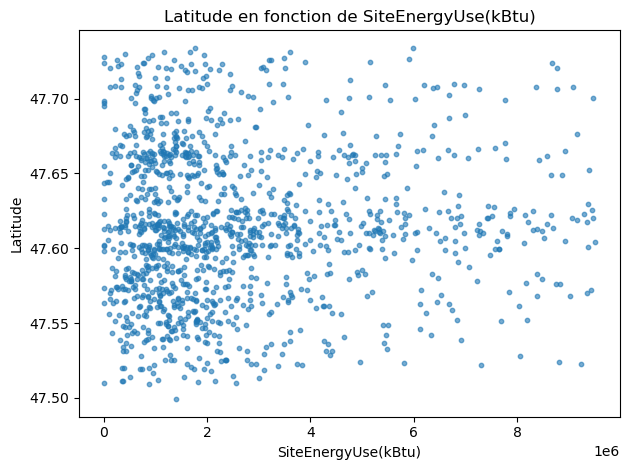

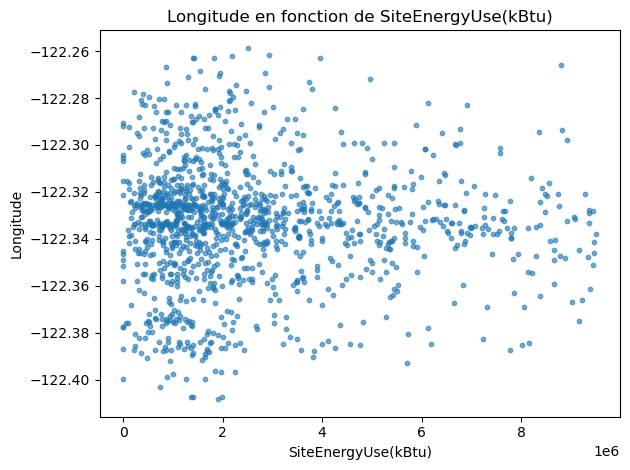

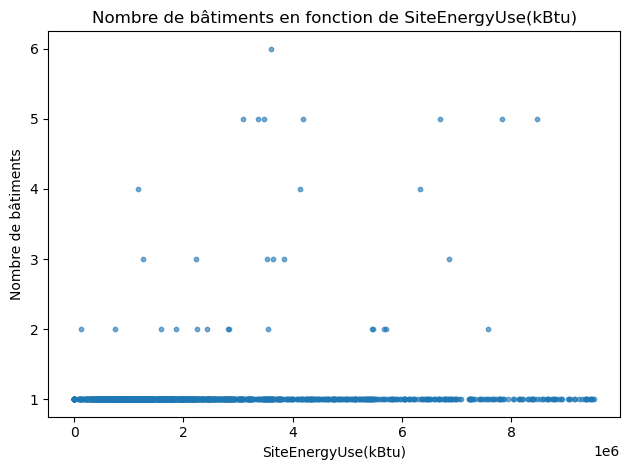

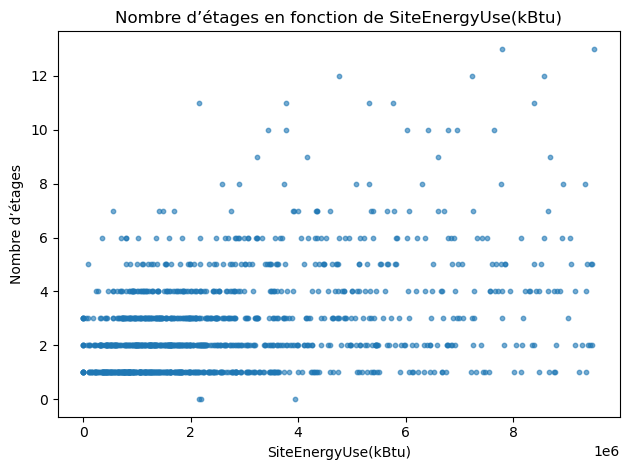

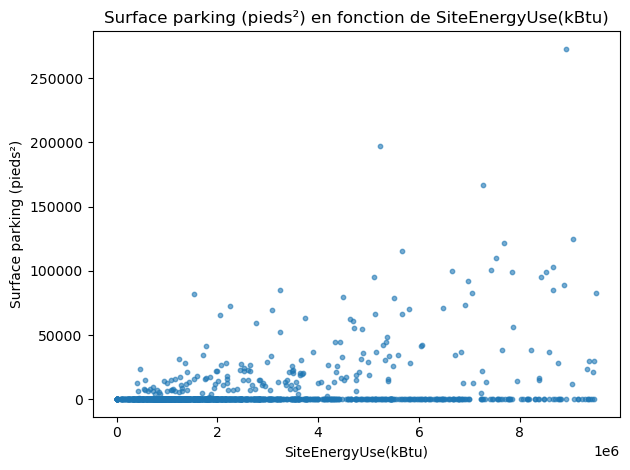

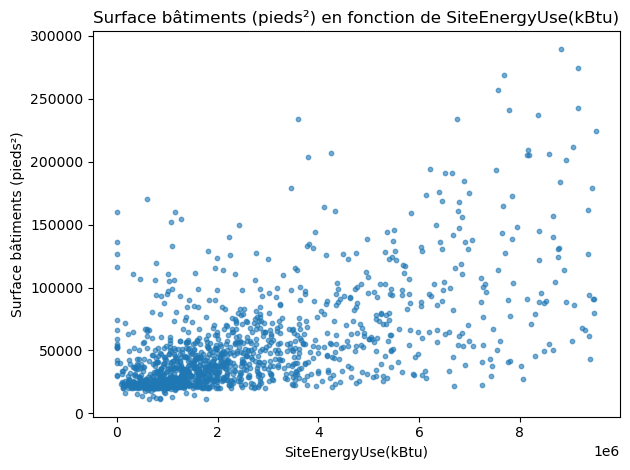

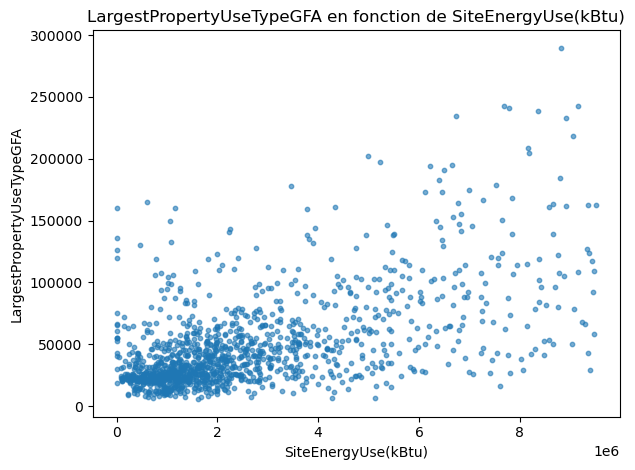

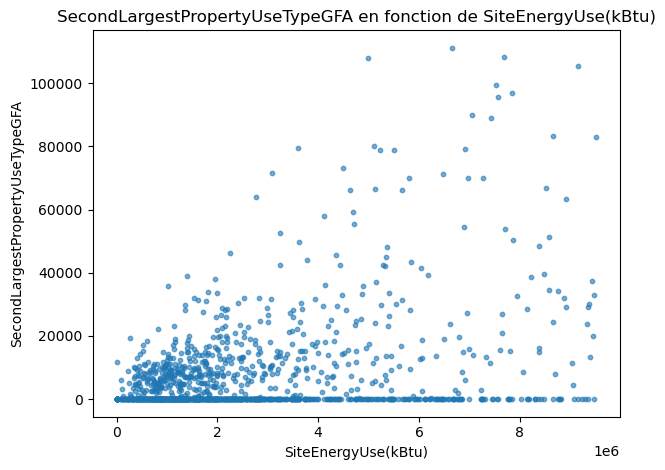

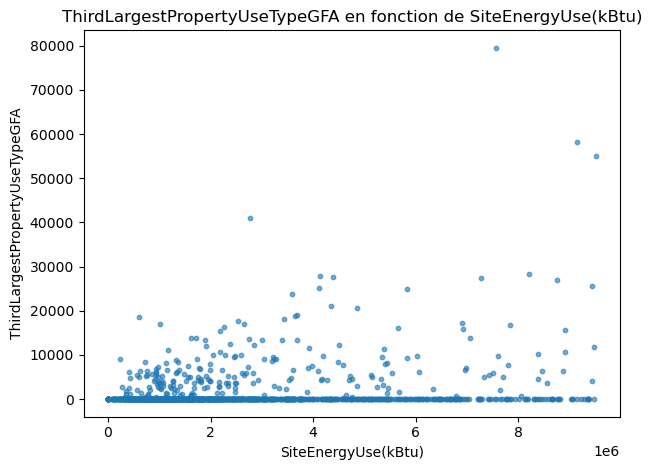

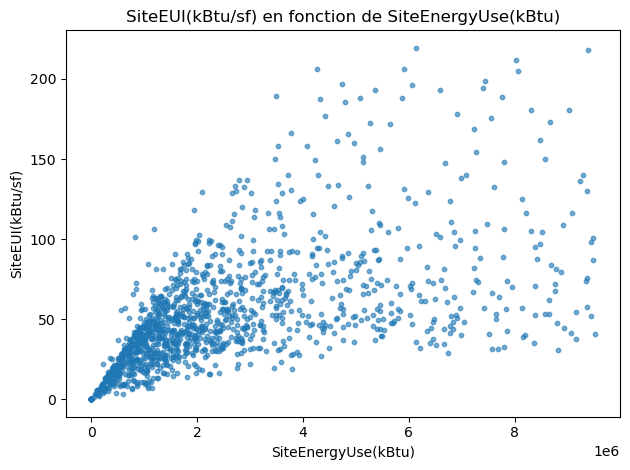

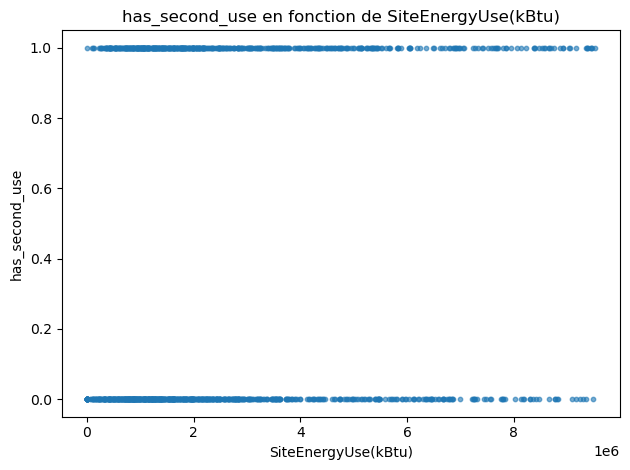

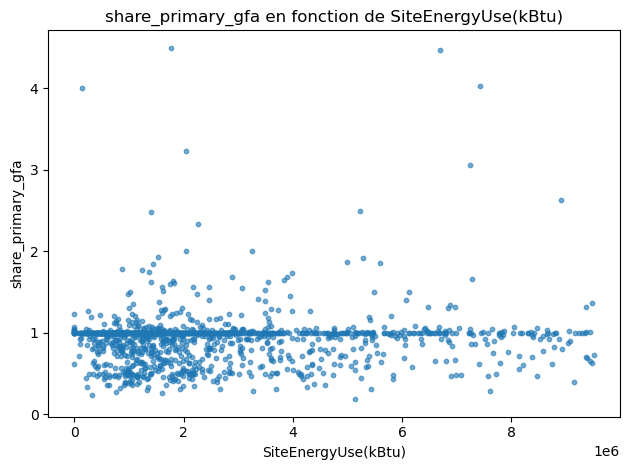

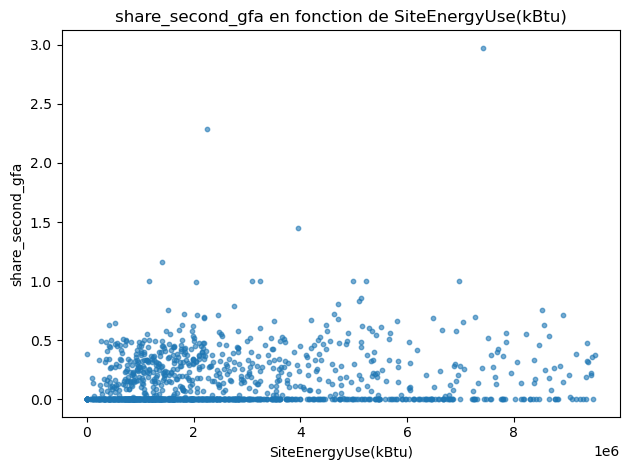

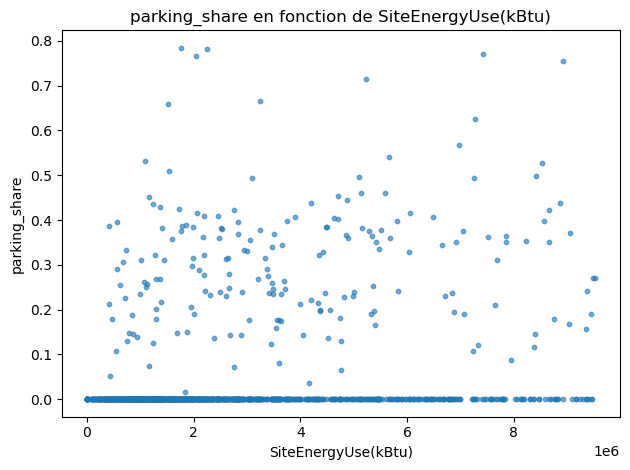

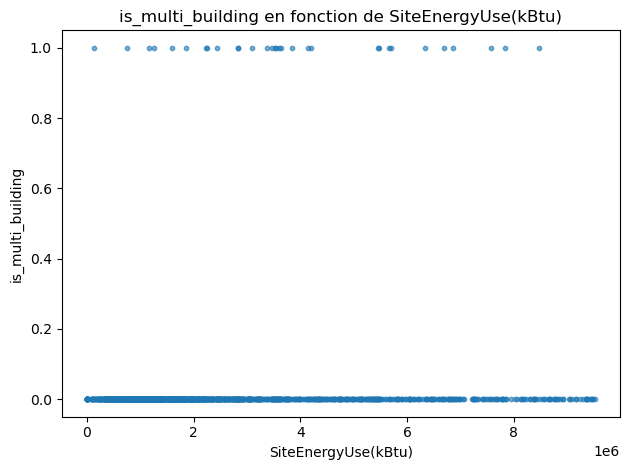

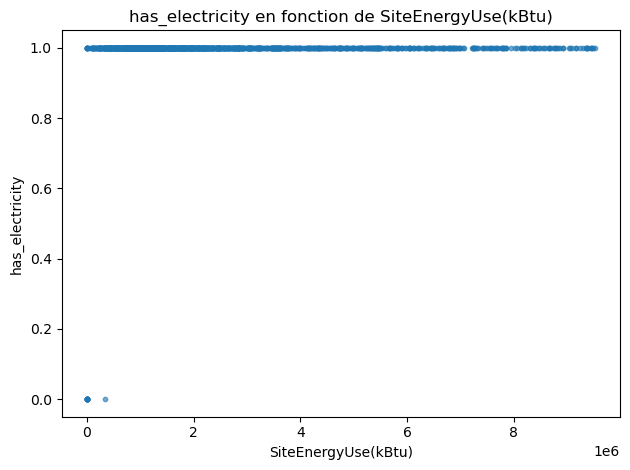

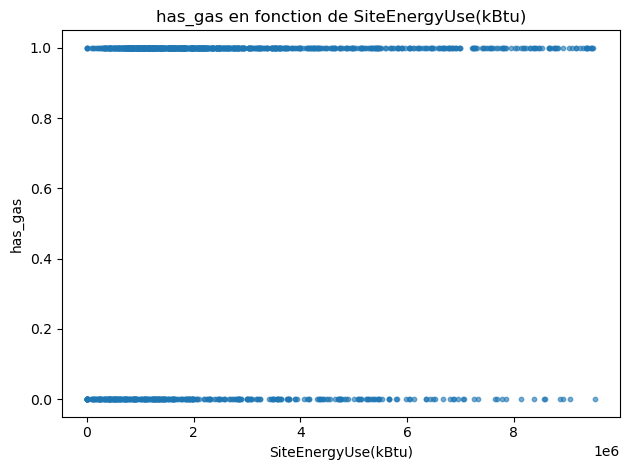

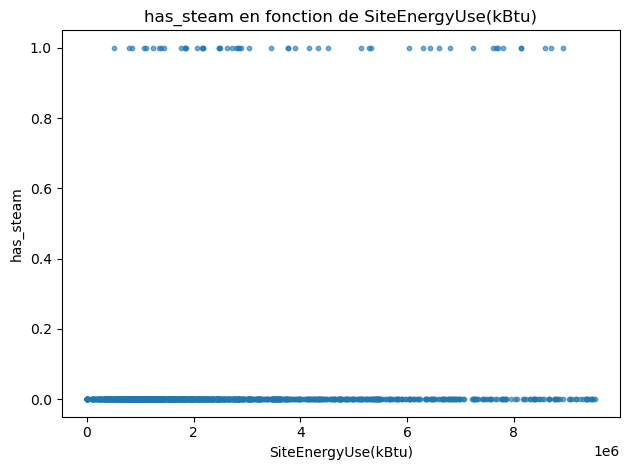

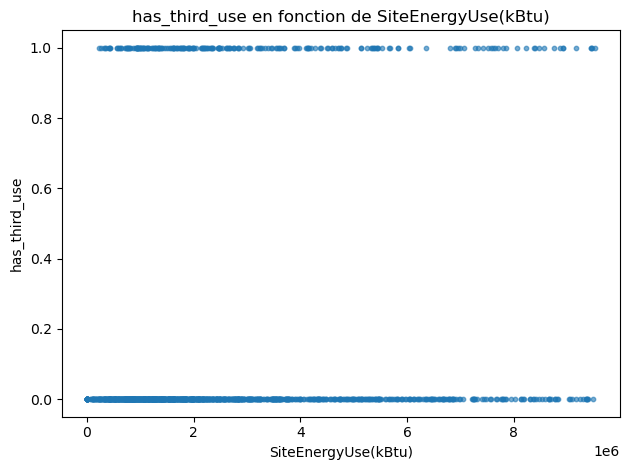

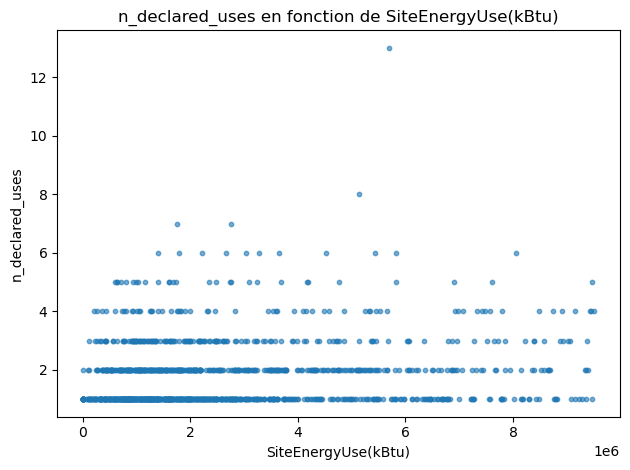

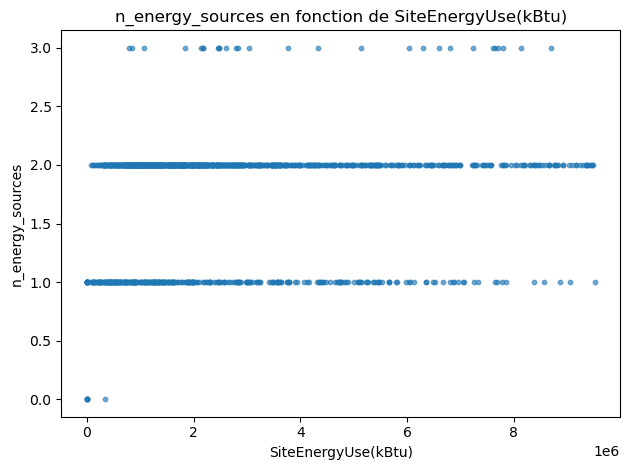

In [137]:
# Abscisse fixée
abscisse = "SiteEnergyUse(kBtu)"

# Candidats automatiques en ordonnée, numériques, hors identifiants et abscisse
exclusions = {"OSEBuildingID", "ZipCode", "CouncilDistrictCode", abscisse}
candidats = [
    c for c in data_etape_1_clean.select_dtypes(include="number").columns
    if c not in exclusions and data_etape_1_clean[c].nunique(dropna=True) > 1
]

# Libellés en français
libelles = {
    "PropertyGFATotal": "Surface totale (pieds²)",
    "PropertyGFABuilding(s)": "Surface bâtiments (pieds²)",
    "PropertyGFAParking": "Surface parking (pieds²)",
    "NumberofFloors": "Nombre d’étages",
    "YearBuilt": "Année de construction", 
    "NumberofBuildings" : "Nombre de bâtiments",
    
}

# Tracé, une figure par candidat
assert abscisse in data_etape_1_clean.columns, f"Abscisse absente: {abscisse}"
for y in candidats:
    data_xy = data_etape_1_clean[[abscisse, y]].dropna()
    if data_xy.empty:
        continue
    plt.figure()
    plt.scatter(data_xy[abscisse], data_xy[y], s=10, alpha=0.6)
    plt.xlabel(libelles.get(abscisse, abscisse))
    plt.ylabel(libelles.get(y, y))
    plt.title(f"{libelles.get(y, y)} en fonction de {libelles.get(abscisse, abscisse)}")
    plt.tight_layout()
    plt.show()

Création de colonnes interessantes

### Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target). 

In [138]:
cible = "SiteEnergyUse(kBtu)"

colonnes_a_exclure = [cible]

X = data_etape_1_clean.drop(columns=[c for c in colonnes_a_exclure])
y = data_etape_1_clean[cible]

display(X.head())



,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),...,parking_share,is_multi_building,has_electricity,has_gas,has_steam,has_third_use,n_declared_uses,building_age_class,n_energy_sources,zip_group_3
0,NonResidential,Hotel,7,DOWNTOWN,47.61220,-122.33799,1,12,0,88434,...,0.000000,0,1,1,1,0,1,pre_1950,3,seattle_other
1,NonResidential,Hotel,7,DOWNTOWN,47.61317,-122.33393,1,11,15064,88502,...,0.145453,0,1,1,0,1,3,1980_1999,2,seattle_other
2,NonResidential,Hotel,7,DOWNTOWN,47.61412,-122.33664,1,10,0,61320,...,0.000000,0,1,1,1,0,1,pre_1950,3,seattle_other
4,NonResidential,Hotel,7,DOWNTOWN,47.61390,-122.33283,1,11,0,83008,...,0.000000,0,1,1,0,0,1,pre_1950,2,seattle_other
5,NonResidential,Other,7,DOWNTOWN,47.61327,-122.33136,1,8,0,102761,...,0.000000,0,1,1,1,0,1,pre_1950,3,seattle_other


### Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne. Les deux méthodes d'encodage à connaitre sont le OneHotEncoder et le LabelEncoder

Export de X pour mieux visualiser

In [139]:
# CSV
X.to_csv("X_export.csv", index=False)
print("Écrit X_export.csv")


Écrit X_export.csv


Encodage

OneHotEncoder méthode

In [140]:
# Colonnes catégorielles explicites
cols_cat = [
    "BuildingType",
    "PrimaryPropertyType",
    "LargestPropertyUseType", 
    "CouncilDistrictCode",
    "SecondLargestPropertyUseType",
    "ThirdLargestPropertyUseType",
    "Neighborhood",
    "zip_group_3",
    
]

# On encode uniquement ces colonnes-là
X_OHE = pd.get_dummies(X, columns=cols_cat, drop_first=False)

print("Forme finale de X_OHE :", X_OHE.shape)
display(X_OHE.head())



Forme finale de X_OHE : (1296, 200)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),...,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,zip_group_3_other_980,zip_group_3_seattle_other
0,47.61220,-122.33799,1,12,0,88434,88434.0,0.0,0.0,81.699997,...,False,False,False,False,False,False,False,False,False,True
1,47.61317,-122.33393,1,11,15064,88502,83880.0,15064.0,4622.0,94.800003,...,False,False,False,False,False,False,False,False,False,True
2,47.61412,-122.33664,1,10,0,61320,61320.0,0.0,0.0,110.800003,...,False,False,False,False,False,False,False,False,False,True
4,47.61390,-122.33283,1,11,0,83008,81352.0,0.0,0.0,70.800003,...,False,False,False,False,False,False,False,False,False,True
5,47.61327,-122.33136,1,8,0,102761,102761.0,0.0,0.0,61.299999,...,False,False,False,False,False,False,False,False,False,True


LabelEncoder

In [ ]:
# Méthode 2, Label Encoding sur toutes les catégorielles
X_LE = X.copy()
for c in cols_cat:
    X_LE[c] = LabelEncoder().fit_transform(X_LE[c].astype(str))

Export en csv

In [206]:
X_OHE.to_csv("X_OHE.csv", index=False)
y.to_csv("y.csv", index= False)
